### Benchmarking Performance of Trend Filtering for Extrapolation in Simulations and Real Data

Methods
- Trend Filtering (TF)
- Linear Regression (LR)
- Linear Splines (LS)
- Kernel Smoothers (KS)

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

# simulation imports
from simulations.generate_sims import generate_samples, generate_true_dgp
from prior_models.uniform_prior import Uniform_Prior
from prior_models.normal_prior import Normal_Prior
from prior_models.kernel_smooth import Kernel_Smooth_Prior

# trend filtering imports
from matrix_algorithms.difference_matrix import Difference_Matrix
from trend_filtering.adaptive_tf import adaptive_tf
from continous_tf import Continous_TF
from trend_filtering.cv_tf import cross_validation

### Generate Data (Simulations)

Simulations consist of true functions that are piecewise linear with noisy samples

True changepoints: [ 65 137 188]


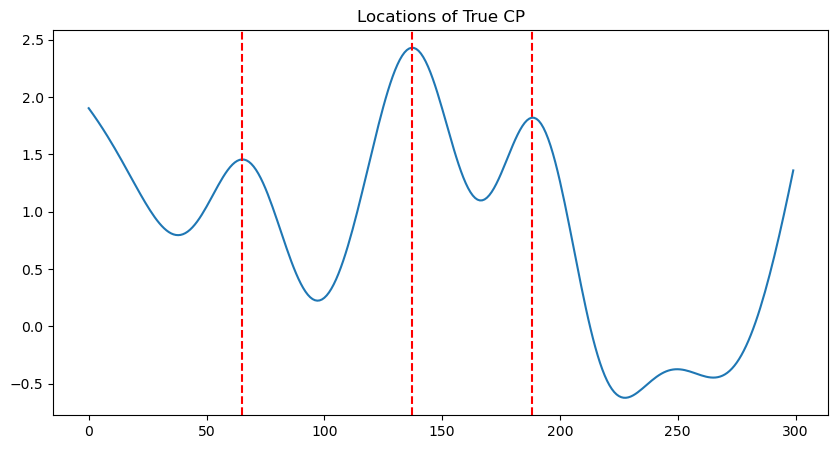

In [2]:
n=300

# generate prior for changepoint locations
prior = Kernel_Smooth_Prior(Normal_Prior(n,mu=1,sigma=10))

# generate true data
true, true_knots, cp_knots = generate_true_dgp(prior, "piecewise_linear", label_style="k_local_spikes")

print(f"True changepoints: {true_knots}")

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("Locations of True CP")
ax.plot(prior.prior)
for i in true_knots:
    ax.axvline(i, color='r', linestyle='--')

### Let's Draw Some Samples

In [3]:
adjusted_true,samples=generate_samples(true, prior.t, true_knots, snr=5)

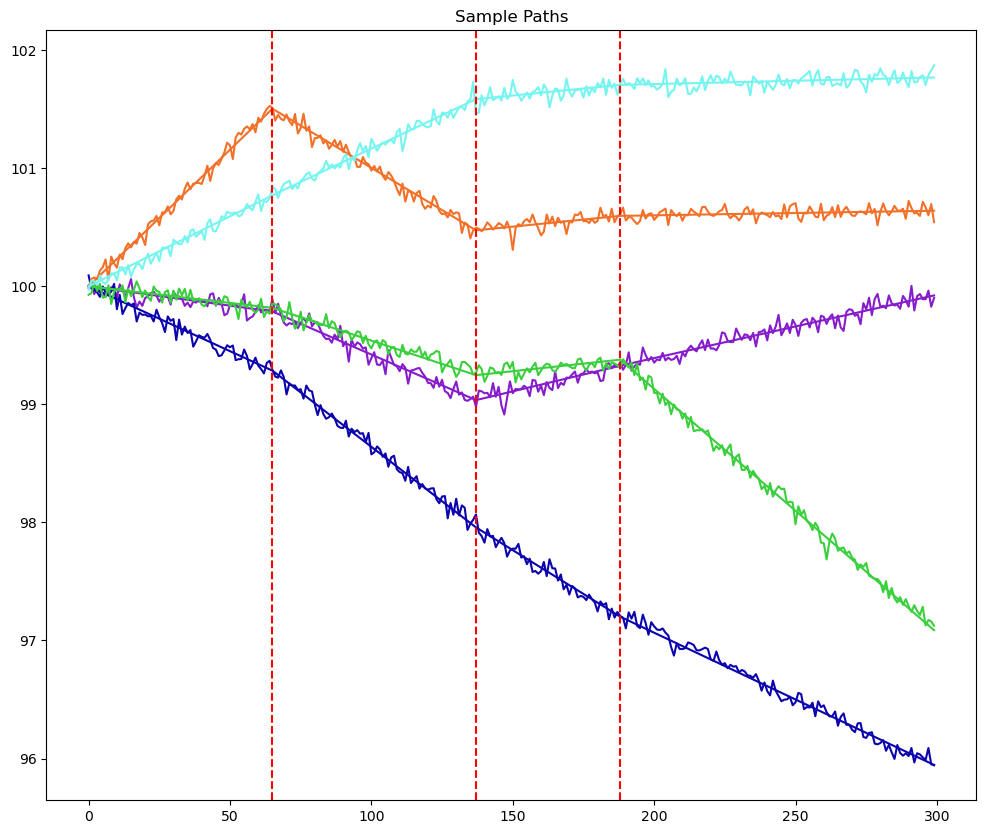

In [4]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title("Sample Paths")
n_samples = samples.shape[0]



for i in range(n_samples):
    random_color = np.random.rand(3,)
    ax.plot(samples[i,:], color=random_color)
    ax.plot(adjusted_true[i,:], color=random_color)

for i in true_knots:
    ax.axvline(i, color='r', linestyle='--')


### Train Each Method on first 250 observations

Again recall the methods are:
- Trend Filtering (TF)
- Linear Regression (LR)
- Linear Splines (LS)
- Kernel Smoothers (KS)


### Trend Filtering

Best lambda: 9.75569080388836
Estimated changepoints: [73, 142]
True changepoints: [ 65 137 188]
Extrapolation MSE: 0.0006454041445626932
 
Best lambda: 0.8599392653750764
Estimated changepoints: [65, 162]
True changepoints: [ 65 137 188]
Extrapolation MSE: 0.012112522796550795
 
Best lambda: 0.3256342923065583
Estimated changepoints: [183]
True changepoints: [ 65 137 188]
Extrapolation MSE: 0.04391032819652805
 
Best lambda: 1.1155608267023975
Estimated changepoints: [67, 141]
True changepoints: [ 65 137 188]
Extrapolation MSE: 0.0005353744093731104
 
Best lambda: 8.263743675500208
Estimated changepoints: [143]
True changepoints: [ 65 137 188]
Extrapolation MSE: 9.68495050467462e-05
 


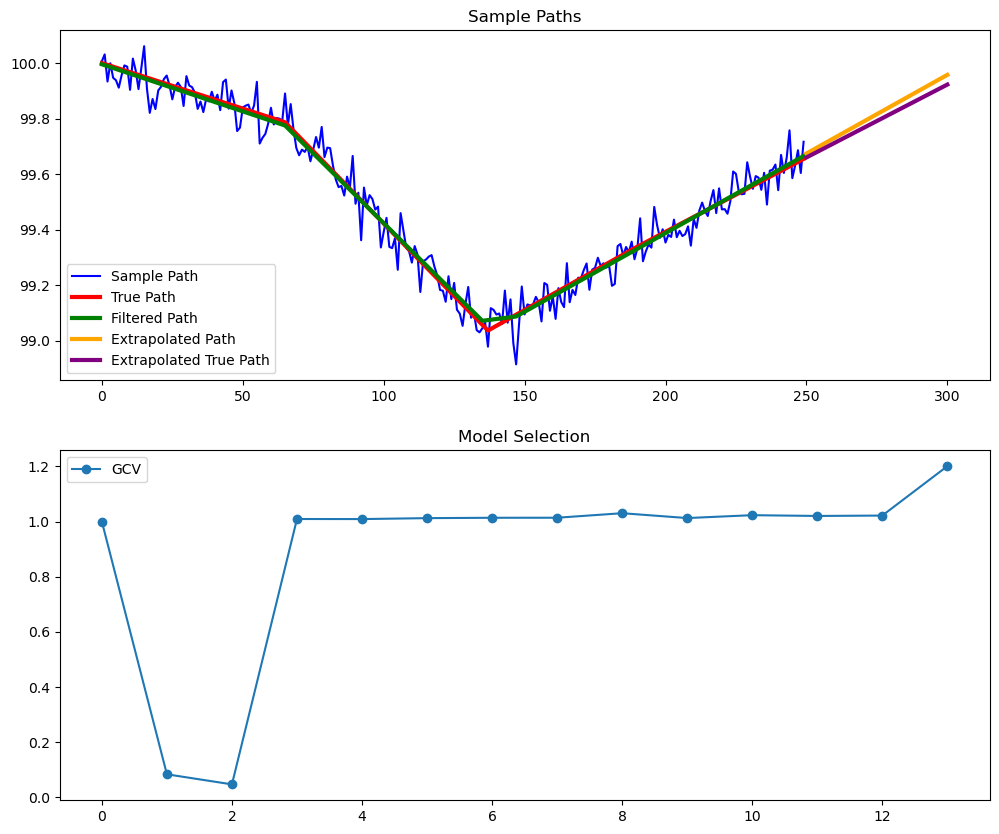

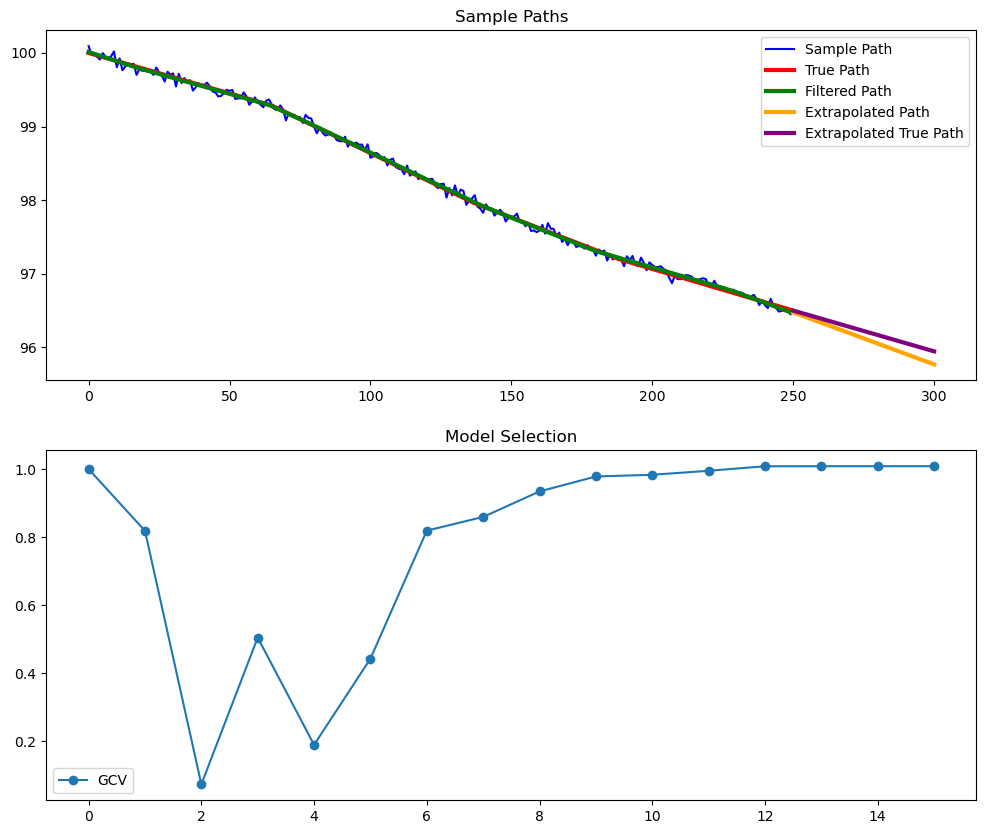

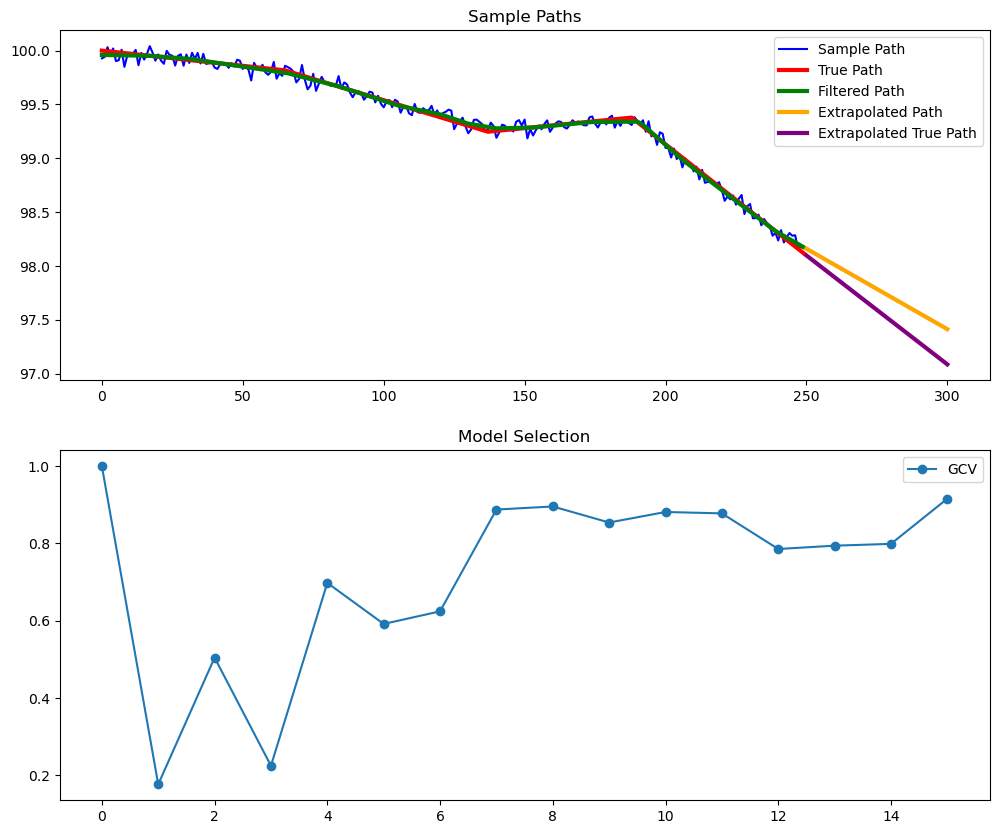

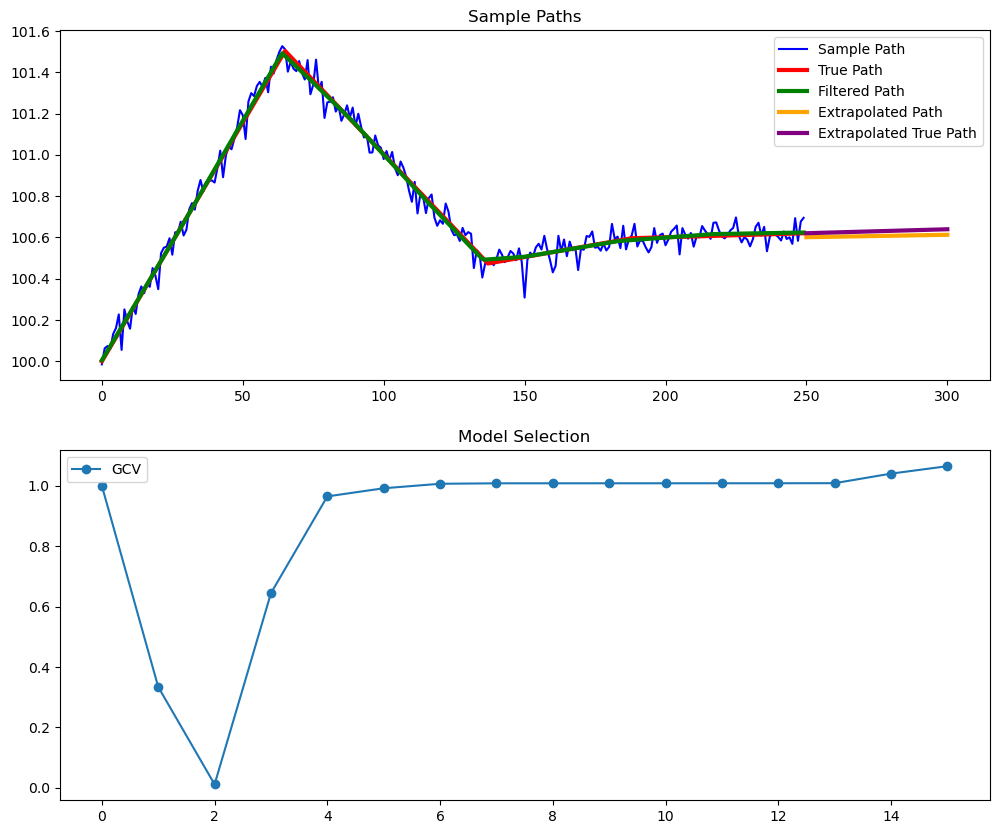

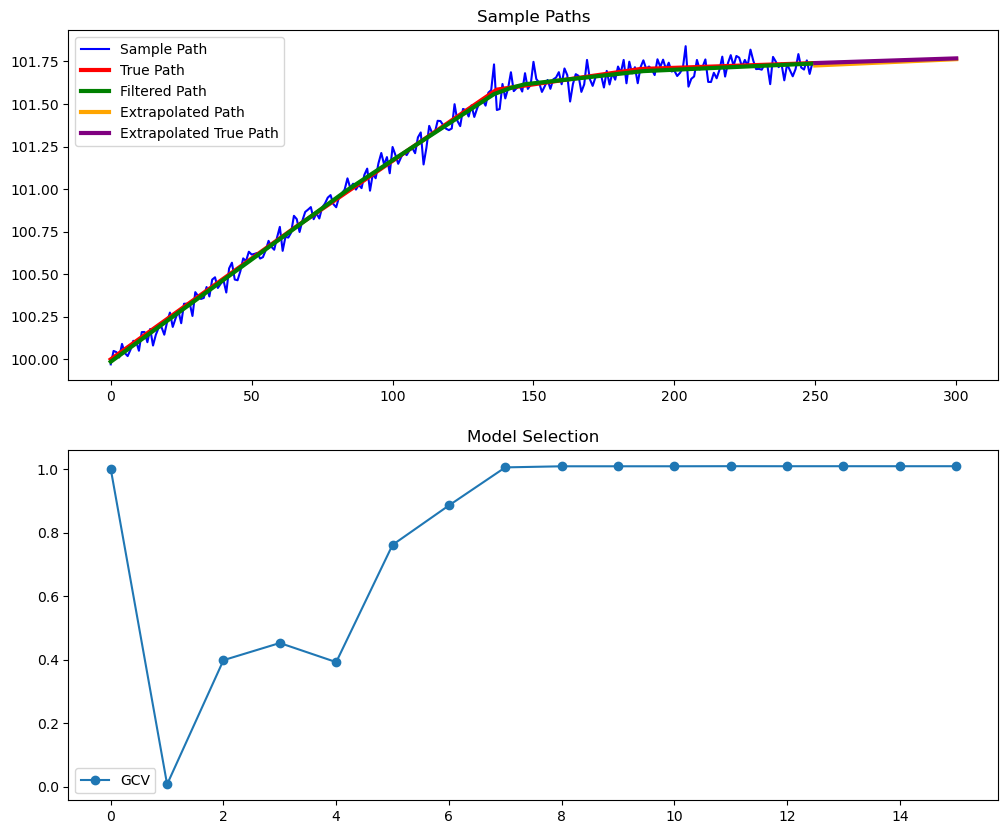

In [5]:
k=250


for k_sample in range(samples.shape[0]):

    D=Difference_Matrix(250,k=1)
    best_lambda=cross_validation(samples[k_sample,:k].reshape(-1,1), D,cv_folds=15,cv_iterations=3,verbose=False)

    print(f"Best lambda: {best_lambda}")

    results=adaptive_tf(samples[k_sample,:k].reshape(-1,1), D, best_lambda,select_knots=True,true_knots=true_knots)
    sorted_gcvs=sorted(results['sol'].gcv_scores, key=lambda x: x[0])

    predictions=results['sol'].predict(np.linspace(k,n,n-k))

    print(f"Estimated changepoints: {results['sol'].knots}")
    print(f"True changepoints: {true_knots}")
    
    print(f"Extrapolation MSE: {np.mean((predictions-adjusted_true[k_sample,k:])**2)}")
    print(" ")

    fig, ax = plt.subplots(2,1, figsize=(12,10))
    ax[0].set_title("Sample Paths")
    ax[0].plot(samples[k_sample,:k], color='b', label="Sample Path")
    ax[0].plot(adjusted_true[k_sample,:k], color='r', label="True Path",lw=3)
    ax[0].plot(results['sol'].x, color='g', label="Filtered Path",lw=3)
    ax[0].plot(np.linspace(k,n,n-k),predictions , color='orange', label="Extrapolated Path",lw=3)
    ax[0].plot(np.linspace(k,n,n-k), adjusted_true[k_sample,k:], color='purple', label="Extrapolated True Path",lw=3)
    ax[0].legend()

    ax[1].set_title("Model Selection")
    ax[1].plot([i[0] for i in sorted_gcvs], [i[1] for i in sorted_gcvs], label="GCV",marker='o')
    ax[1].legend()
    
    



  


### Segmented Linear Regression

### Linear Regression Splines with Explicit Knots

### Kernels Regression with Fixed Bandwidth Parameteter

In [6]:
sys.path.append('../../kernel_methods')

from Kernel_Smoother import KernelSmoother

Optimal Bandwidth: 25.35500933593558
Optimal Bandwidth: 25.35500933593558
Optimal Bandwidth: 25.35500933593558
Optimal Bandwidth: 25.35500933593558
Optimal Bandwidth: 25.35500933593558


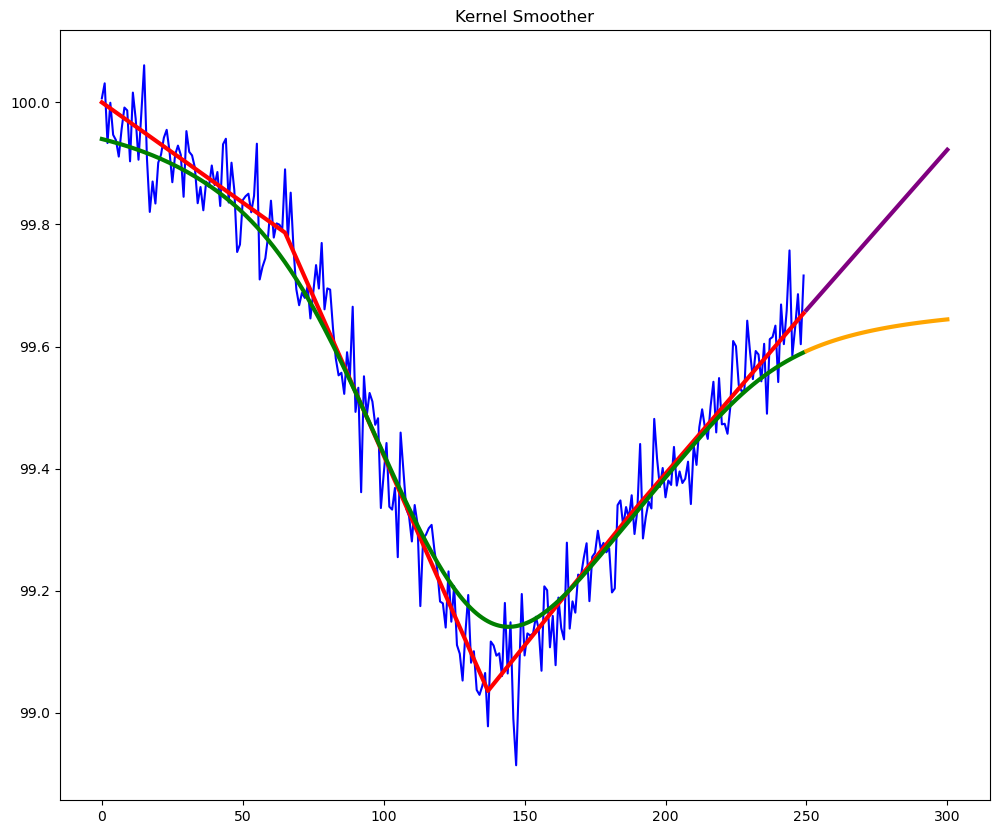

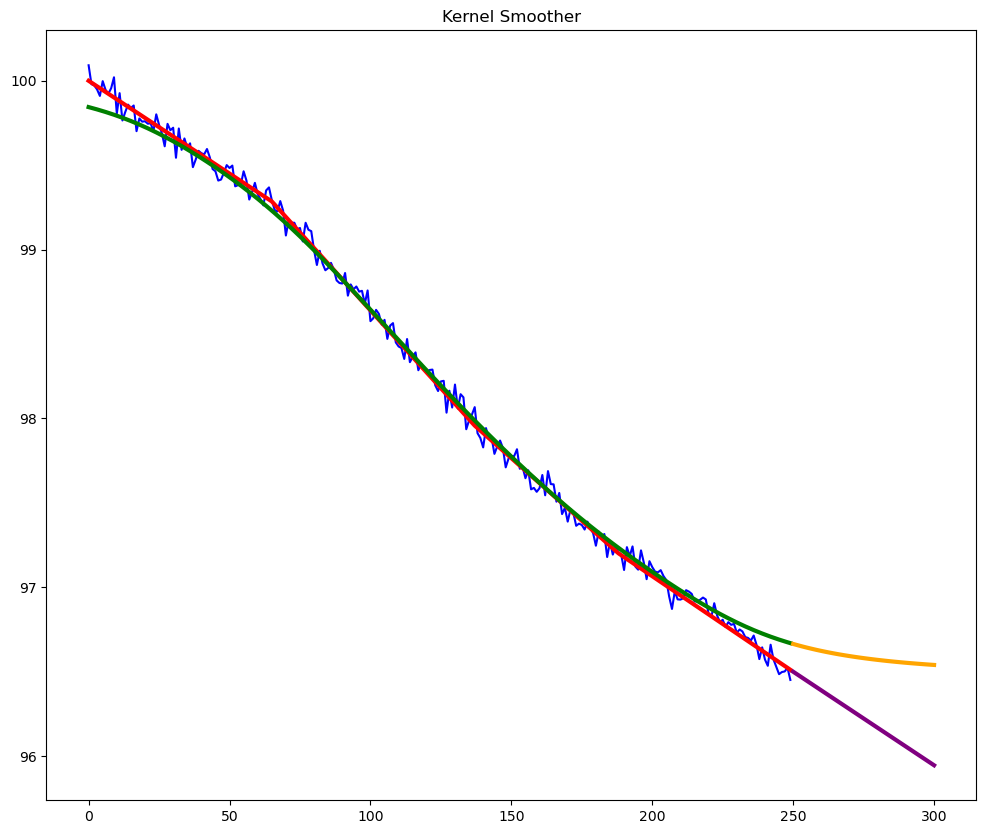

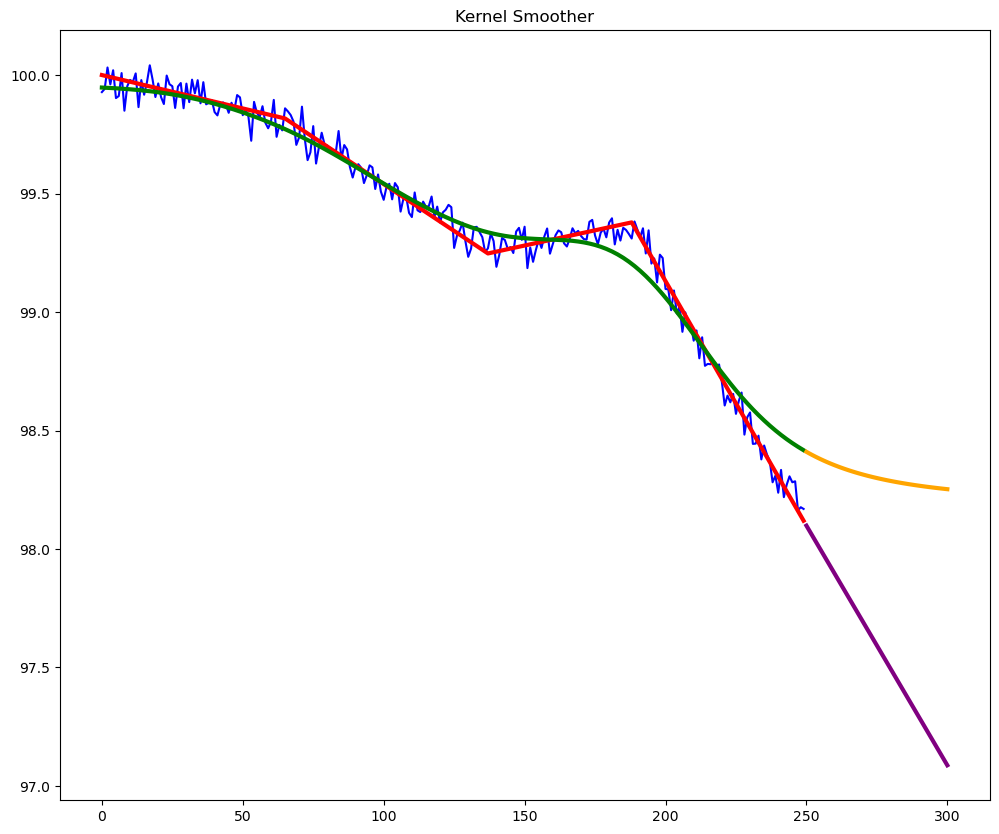

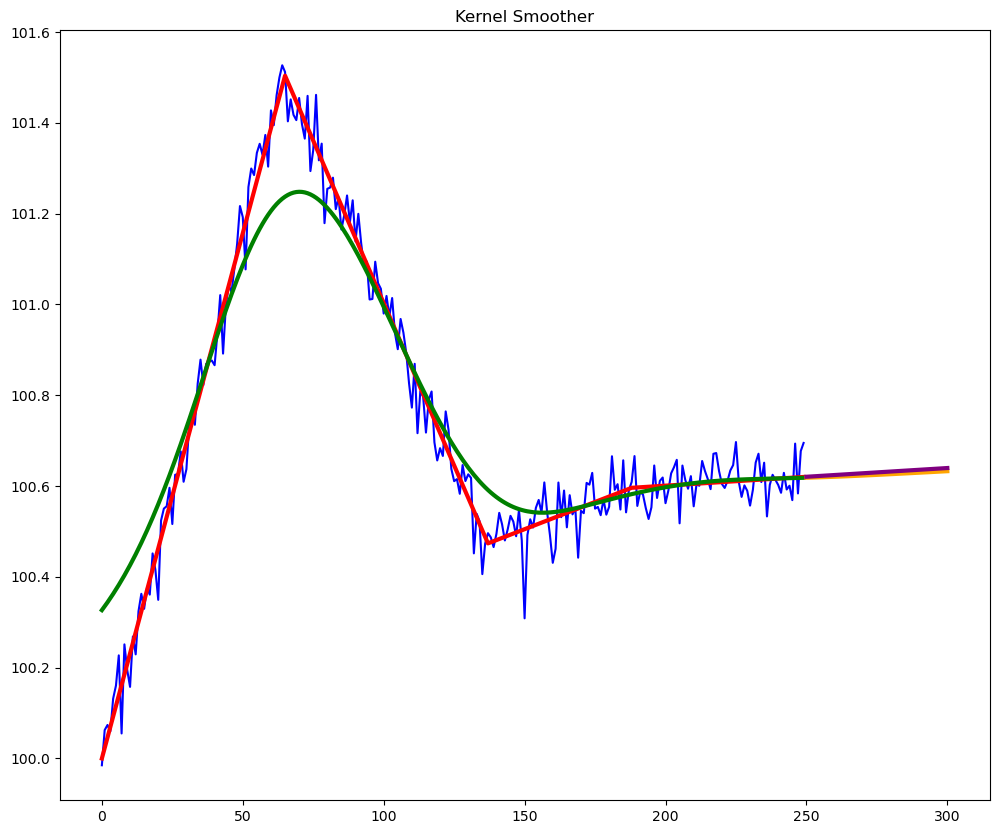

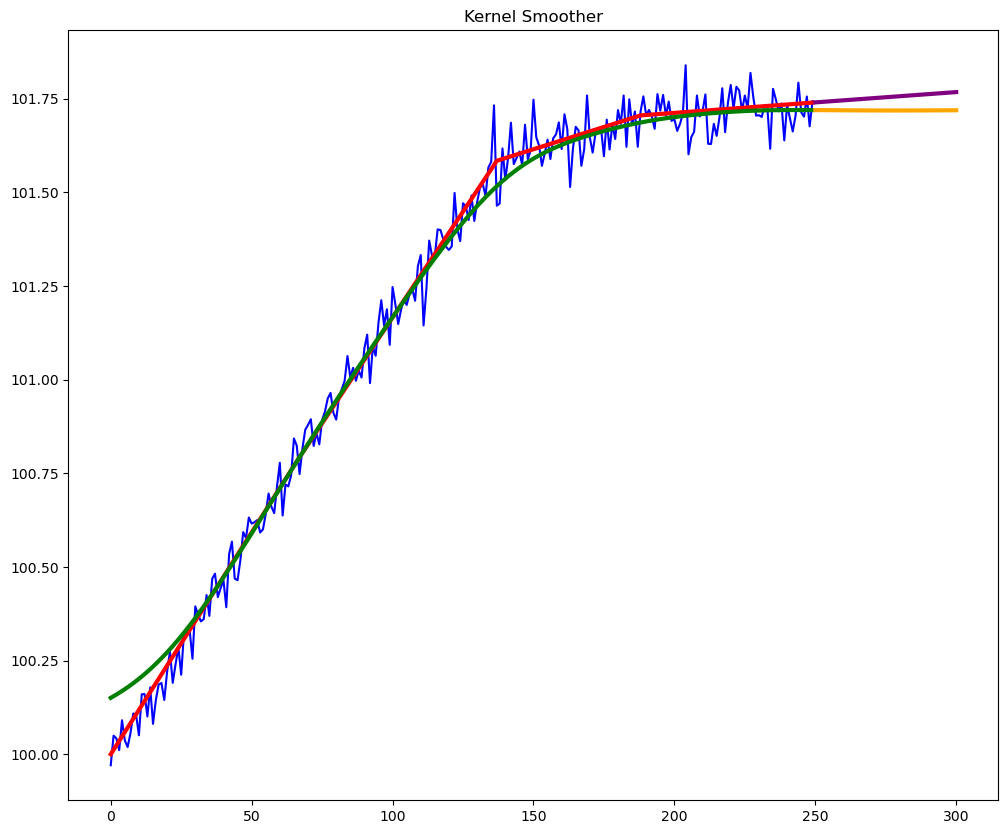

In [7]:
k=250

for k_sample in range(samples.shape[0]):

    trained_model=KernelSmoother(np.arange(0,250), samples[k_sample,:k],bandwidth_style=1)
    kernel_matrix=trained_model.fit()
    smooth_series=trained_model.smooth_series(kernel_matrix)

    print(f"Optimal Bandwidth: {trained_model.optimal_bandwidth}")
    predictions=trained_model.predict(np.linspace(k,n,n-k))
    
    fig, ax = plt.subplots(1,1, figsize=(12,10))
    ax.set_title("Kernel Smoother")
    ax.plot(samples[k_sample,:k], color='b', label="Sample Path")
    ax.plot(adjusted_true[k_sample,:k], color='r', label="True Path",lw=3)
    ax.plot(smooth_series, color='g', label="Filtered Path",lw=3)
    ax.plot(np.linspace(k,n,n-k),predictions , color='orange', label="Extrapolated Path",lw=3)
    ax.plot(np.linspace(k,n,n-k), adjusted_true[k_sample,k:], color='purple', label="Extrapolated True Path",lw=3)
    
